In [17]:
# # For data cleaning, structuring, analysis, and visualization
# # we will be using pandas and numpy:
# =============================================================================

import pandas as pd
import numpy as np
import os            # for directory management
import json
import textwrap
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import plotly as py
import plotly_express as px
import plotly.offline as p_off
from plotly.offline import init_notebook_mode, iplot
import warnings
import pygwalker as pyg
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from math import log10


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


print(pd.__version__)



1.1.5


# Read  and preprocess data

In [18]:
data=pd.read_excel('sample_data.xlsx',sheet_name='raw_data')

# Calculate the percentage of missing values in each column
null_percentages = data.isnull().mean() * 100
print(null_percentages[null_percentages > 0].index.tolist())

#create list of categorical and numeric columns exclding id
cat_cols=data.select_dtypes(include=['object']).drop(['enumerator'],axis=1).columns.to_list()
display(cat_cols)

num_cols=data.select_dtypes(exclude=['object'])

num_cols_1=num_cols.columns
num_cols_2=data[num_cols_1]
cat_cols_1=data[cat_cols]

# Convert the categorical features to integers using LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    
    
    
display(data.head())

[]


['competitive_advantage']

,enumerator,loan_amount,loan_number,monthly_sales,monthly_turnover,businesses_number,competitive_advantage
0,e1,15000,3,55000,45000,1,3
1,e5,40000,1,800000,100000,3,0
2,e2,20000,3,70000,15000,2,3
3,e3,40000,1,172000,120000,1,3
4,e0,80000,1,150000,150000,1,2


# Check for data anomalies

3-sigma rule

In [23]:
# Check for outliers using a 3-sigma rule
numeric_cols = data.select_dtypes(include=[np.number]).columns

outliers_data=pd.DataFrame([])
for col in numeric_cols:
    mean = data[col].mean()
    std = data[col].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)].reset_index()
    
    if not outliers.empty:
        outliers['col']=col
        outliers_data=outliers_data.append(outliers)
        
        
outliers_data.head()

,index,enumerator,loan_amount,loan_number,monthly_sales,monthly_turnover,businesses_number,competitive_advantage,col
0,4,e0,80000,1,150000,150000,1,2,loan_amount
1,11,e6,80000,1,120000,150000,2,2,loan_amount
2,19,e4,80000,1,1000,2000,1,3,loan_amount
3,22,e4,80000,3,220000,250000,3,0,loan_amount
4,40,e0,80000,1,5000000,800000,2,0,loan_amount


In [24]:
outliers_data.groupby(['enumerator']).loan_amount.count().reset_index()

,enumerator,loan_amount
0,e0,14
1,e1,6
2,e2,2
3,e3,4
4,e4,8
5,e5,8
6,e6,12
7,e7,9
8,e8,9
9,e9,8


# Heat map- all

In [25]:
data.head()

,enumerator,loan_amount,loan_number,monthly_sales,monthly_turnover,businesses_number,competitive_advantage
0,e1,15000,3,55000,45000,1,3
1,e5,40000,1,800000,100000,3,0
2,e2,20000,3,70000,15000,2,3
3,e3,40000,1,172000,120000,1,3
4,e0,80000,1,150000,150000,1,2


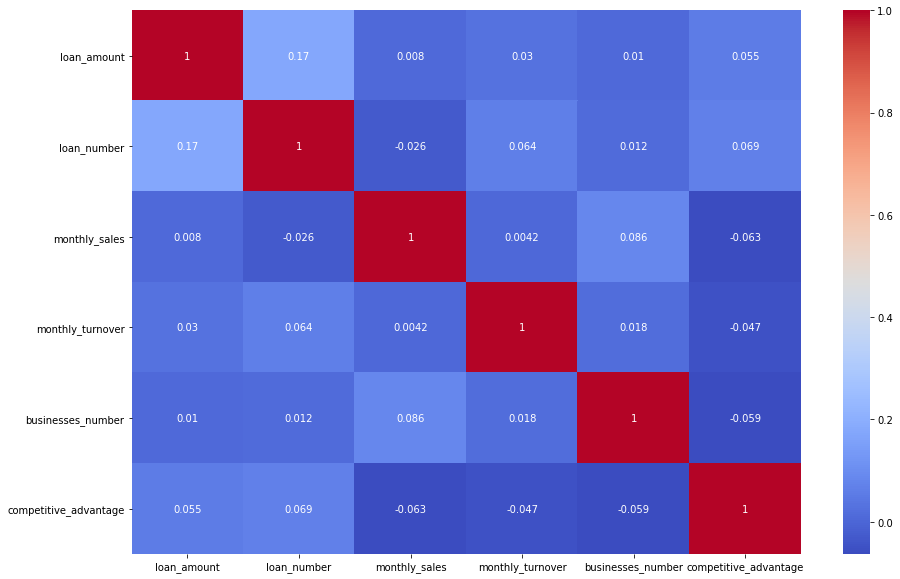

In [27]:
#data subset categorical
data_subset_c=cat_cols_1.copy()

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Create heatmap using Seaborn

data_subset_all=data.drop(['enumerator'],axis=1)


if len(data_subset_c) > 0:
    sns.heatmap(data_subset_all.corr(),cmap='coolwarm', ax=ax, annot=True)
 

# Line Plot - Numerics only 

In [29]:
data.head()

,enumerator,loan_amount,loan_number,monthly_sales,monthly_turnover,businesses_number,competitive_advantage
0,e1,15000,3,55000,45000,1,3
1,e5,40000,1,800000,100000,3,0
2,e2,20000,3,70000,15000,2,3
3,e3,40000,1,172000,120000,1,3
4,e0,80000,1,150000,150000,1,2


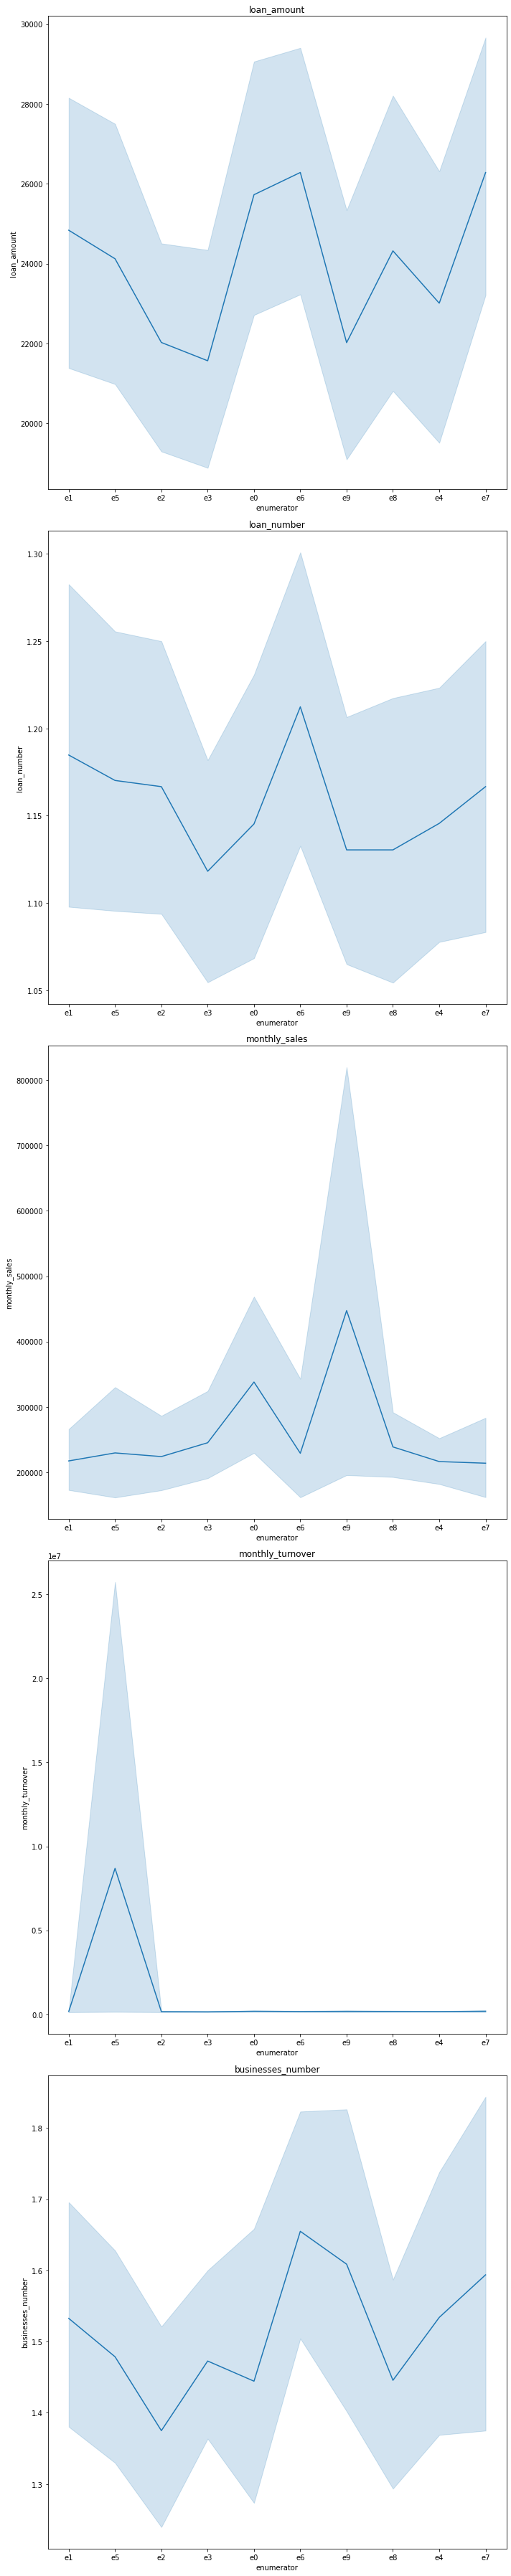

In [30]:
# Define the categorical id column and the list of numeric columns to plot


# Create subplots for each numeric column
fig, axes = plt.subplots(nrows=len(num_cols_1), figsize=(10, 50))

# Loop through each numeric column and create a line plot
for i, col in enumerate(num_cols_1):
    sns.lineplot(ax=axes[i], data=data, x='enumerator', y=col)
    axes[i].set_title(col)

# Display the plot
plt.tight_layout()
plt.show()

# Benfords law -  detect fake and random data

In [31]:
# Function to check if denominator is not zero
def check_zero(x):
    if x == 0:
        return np.nan
    else:
        return x

# Function to check Benford's Law
def check_benford(df, col_list):
    results = pd.DataFrame(columns=['Column', 'enumerator', 'Benford Check'])

    for col in col_list:
        for id in df['enumerator'].unique():
            temp_df = df[df['enumerator']==id].copy()
            temp_df[col] = temp_df[col].apply(lambda x: abs(x))
            temp_df[col] = temp_df[col].apply(lambda x: check_zero(x))
            temp_df = temp_df.dropna(subset=[col])
            first_digit = temp_df[col].astype(str).str[0].astype(int)
            benford = pd.Series([np.log10(1+1/n) for n in range(1,10)])
            expected_counts = benford * len(temp_df)
            actual_counts = first_digit.value_counts().sort_index()
            chi_square_stat = (((actual_counts - expected_counts)**2)/expected_counts).sum()
            results = results.append({'Column': col, 'enumerator': id, 'Benford Check': chi_square_stat}, ignore_index=True)

    results['Benford Check'] = np.where(results['Benford Check']<=15.51, 'OK', 'Fake')
    return results

ben_fake=check_benford(data, num_cols_1)
ben_fake.groupby(['enumerator','Benford Check']).Column.count().reset_index()

,enumerator,Benford Check,Column
0,e0,Fake,5
1,e1,Fake,5
2,e2,Fake,5
3,e3,Fake,5
4,e4,Fake,4
5,e4,OK,1
6,e5,Fake,5
7,e6,Fake,5
8,e7,Fake,5
9,e8,Fake,4


# Isolation forest- outlier detection

In [32]:
data.head()

,enumerator,loan_amount,loan_number,monthly_sales,monthly_turnover,businesses_number,competitive_advantage
0,e1,15000,3,55000,45000,1,3
1,e5,40000,1,800000,100000,3,0
2,e2,20000,3,70000,15000,2,3
3,e3,40000,1,172000,120000,1,3
4,e0,80000,1,150000,150000,1,2


In [35]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest model with default parameters
iso_forest = IsolationForest()

#columns to use for isolation
cols=data.drop(['enumerator'],axis=1).columns

# Fit the model to the data
iso_forest.fit(data[cols])

# Predict outliers using the trained model
outliers = iso_forest.predict(data[cols])

# Add a new column to the DataFrame indicating whether each record is an outlier or not
data['is_outlier'] = outliers

outliers=data[(data.is_outlier==-1)]

#outliers['enumerator']=outliers['respid'].str[:3]

outliers.groupby(['enumerator']).loan_amount.count()


enumerator
e0    30
e1    25
e2    19
e3    22
e4    22
e5    21
e6    31
e7    18
e8    23
e9    24
Name: loan_amount, dtype: int64